In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

In [2]:
df_train = pd.read_csv("Traffic.csv")
df_pred = pd.read_csv("predictions2.csv")

df_train.drop(columns=["Date"], inplace=True)

print(df_train.head())
print(df_pred.head())

          Time Day of the week  CarCount  BikeCount  BusCount  TruckCount  \
0  12:00:00 AM         Tuesday        31          0         4           4   
1  12:15:00 AM         Tuesday        49          0         3           3   
2  12:30:00 AM         Tuesday        46          0         3           6   
3  12:45:00 AM         Tuesday        51          0         2           5   
4   1:00:00 AM         Tuesday        57          6        15          16   

   Total Traffic Situation  
0     39               low  
1     55               low  
2     55               low  
3     58               low  
4     94            normal  
     Time Day of the week  CarCount  BikeCount  BusCount  TruckCount  Total
0  170000         Tuesday        29          0         0           0     29
1  170015         Tuesday        23          0         0           1     24
2  170030         Tuesday        24          0         0           3     27
3  170045         Tuesday        29          0         0   

In [3]:
#get rid of the date in the time column
def convert_to_military_time(time_str):
    try:
        # Try to parse as 12-hour format
        return pd.to_datetime(time_str, format='%I:%M:%S %p').strftime('%H:%M:%S')
    except ValueError:
        return pd.to_datetime(time_str, format='%H:%M:%S').strftime('%H:%M:%S')

df_train['Time'] = df_train['Time'].apply(convert_to_military_time)

#replace string attributes with numerical values in the Time column to use it in the model
df_train['Time'] = df_train['Time'].str.replace(':', '').astype(int)

# display new time column
df_train['Time'].head()

0        0
1     1500
2     3000
3     4500
4    10000
Name: Time, dtype: int32

In [4]:
import math
#divide all car counts and total by 10
df_train['CarCount'] = df_train['CarCount'] / 10
df_train['TruckCount'] = df_train['TruckCount'] / 10
df_train['BusCount'] = df_train['BusCount'] / 10
df_train['BikeCount'] = df_train['BikeCount'] / 10  

#round all values to the nearest whole number
df_train['CarCount'] = df_train['CarCount'].apply(lambda x: math.ceil(x))
df_train['TruckCount'] = df_train['TruckCount'].apply(lambda x: math.ceil(x))
df_train['BusCount'] = df_train['BusCount'].apply(lambda x: math.ceil(x))
df_train['BikeCount'] = df_train['BikeCount'].apply(lambda x: math.ceil(x))

#sum all the counts to get the total
df_train['Total'] = df_train['CarCount'] + df_train['TruckCount'] + df_train['BusCount'] + df_train['BikeCount']

#display new values
print(df_train.head())


    Time Day of the week  CarCount  BikeCount  BusCount  TruckCount  Total  \
0      0         Tuesday         4          0         1           1      6   
1   1500         Tuesday         5          0         1           1      7   
2   3000         Tuesday         5          0         1           1      7   
3   4500         Tuesday         6          0         1           1      8   
4  10000         Tuesday         6          1         2           2     11   

  Traffic Situation  
0               low  
1               low  
2               low  
3               low  
4            normal  


In [ ]:
#label encoding - use this on categorical data
Le = LabelEncoder()
df_train['Day of the week'] = Le.fit_transform(df_train['Day of the week'])

# Handle missing categories in df_pred
valid_categories = set(Le.classes_)
df_pred = df_pred[df_pred['Day of the week'].isin(valid_categories)]

# Re-apply LabelEncoder after fixing
df_pred['Day of the week'] = Le.transform(df_pred['Day of the week'])


#create our X and y variables for the model
X = df_train.drop(columns=["Traffic Situation"]) #features
y = df_train["Traffic Situation"] #target variable

#label encoding for the target variable
y = Le.fit_transform(y)

#print the encoded values mapped to the original values
print("Label Encoded Values for Traffic Situation:")
print(dict(zip(Le.transform(Le.classes_), Le.classes_)))

#split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_pred = df_pred

Accuracy: 90.03%
              precision    recall  f1-score   support

           0       0.92      0.97      0.95       197
           1       0.84      0.83      0.83        88
           2       0.78      0.68      0.72        93
           3       0.92      0.93      0.92       515

    accuracy                           0.90       893
   macro avg       0.87      0.85      0.86       893
weighted avg       0.90      0.90      0.90       893



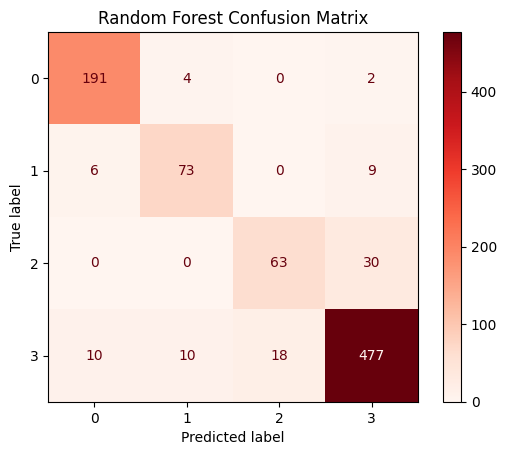

In [7]:
#train the model
model = RandomForestClassifier(random_state=42, n_estimators=1000, criterion="entropy", max_depth=10) 
model.fit(X_train, y_train)

#make predictions
y_pred = model.predict(X_test)

#evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Reds")
plt.title("Random Forest Confusion Matrix")
plt.show()

In [14]:
#print the label encoding variables in correlation with number
print(Le.classes_)

['heavy' 'high' 'low' 'normal']


In [21]:
predictions = model.predict(X_pred)

#inverse transform the predictions to get the original string values
predictions = Le.inverse_transform(predictions)

output = pd.DataFrame(predictions, columns=['Traffic Situation'])

title_for_csv = input("Enter a title for the csv file: ")
output.to_csv("predictions_made_from_predictions.csv", index=False)